# Polar plot for one category, multiple experiments

## Get experiments in this category

In [7]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

In [8]:
targeted_structure = 'VISp'
imaging_depths = [175, 275]
cre_line = 'Cux2-CreERT2'

In [10]:
import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
        targeted_structures = [targeted_structure],
        imaging_depths = imaging_depths,
        cre_lines = [cre_line])
print ("There are", len(exps), "experiments")
exps

There are 16 experiments


[{'id': 704298735,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 111,
  'experiment_container_id': 701412138,
  'session_type': 'three_session_A',
  'donor_name': '382421',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
  'fail_eye_tracking': True},
 {'id': 503109347,
  'imaging_depth': 275,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 101,
  'experiment_container_id': 511510779,
  'session_type': 'three_session_A',
  'donor_name': '225036',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-225036',
  'fail_eye_tracking': True},
 {'id': 524691284,
  'imaging_depth': 275,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 102,
  'experiment_container_id': 524691282,
  'session_type': 'three_session_A',
  'donor_n

## Generate data

Processing experiment 704298735
In this experiment, we have 157 cells, but after filtering, we have 18 cells
Processing experiment 503109347
In this experiment, we have 520 cells, but after filtering, we have 129 cells
Processing experiment 524691284
In this experiment, we have 389 cells, but after filtering, we have 117 cells
Processing experiment 501574836
In this experiment, we have 313 cells, but after filtering, we have 81 cells
Processing experiment 645413759
In this experiment, we have 300 cells, but after filtering, we have 98 cells
Processing experiment 510514474
In this experiment, we have 402 cells, but after filtering, we have 32 cells
Processing experiment 501704220
In this experiment, we have 225 cells, but after filtering, we have 29 cells
Processing experiment 502205092
In this experiment, we have 396 cells, but after filtering, we have 70 cells
Processing experiment 501271265
In this experiment, we have 295 cells, but after filtering, we have 60 cells
Processing experi

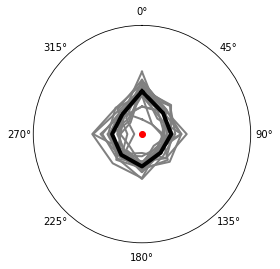

In [11]:
import warnings;
warnings.simplefilter('ignore');
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

def get_avg_cell_polar_in_experiment(boc, ec_id, exp_id, cells):
    """
    Get the polar data for all cells in this experiment, then average them out to get a single polar data.
    """
    in_category_cells = cells[cells.experiment_container_id == ec_id]
    dg_response_filter = get_dg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
    # Filter out based on new_dsi_cell
    new_col = []
    for index, row in filtered_cells.iterrows():
        polardata_for_this_cell = get_avg_normalized_response(
            boc = boc,
            session_id = exp_id,
            cell_specimen_id = row.cell_specimen_id,
            temporal_frequency = 2.0)
        if polardata_for_this_cell is None:
            # Put negative value so dsi selector will ignore this guy.
            new_dsi_cell = -1
        else:
            new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
        new_col.append(new_dsi_cell)
    filtered_cells['new_dsi_cell'] = new_col
    filtered_cells = filtered_cells[filtered_cells.new_dsi_cell > 0.5]

    print ("In this experiment, we have", len(in_category_cells),
           "cells, but after filtering, we have", len(filtered_cells), "cells")
    
    thetas = []
    rs = []
    cell_ids = []
    for cell_specimen_id in filtered_cells.cell_specimen_id:
        one_cell_polar_data_dict = get_avg_normalized_response(
            boc=boc,
            session_id=exp_id,
            cell_specimen_id = cell_specimen_id,
            temporal_frequency=2.0)
        if one_cell_polar_data_dict is None:
            continue
        theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
        thetas.append(theta)
        rs.append(r)
        cell_ids.append(cell_specimen_id)
    if len(thetas) == 0:
        return None, None
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    return agg_theta, agg_r

thetas = []
rs = []
for exp in exps:
    e_id = exp['id']
    ec_id = exp['experiment_container_id']
    print("Processing experiment", e_id)
    theta, r = get_avg_cell_polar_in_experiment(boc, ec_id, e_id, cells)
    thetas.append(theta)
    rs.append(r)

agg_theta, agg_r = get_avg_polar(thetas, rs)

## Plot em

### Final result

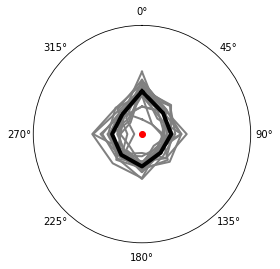

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
    bold_theta = agg_theta,
    bold_r = agg_r,
    grey_thetas = thetas, 
    grey_rs = rs)

### Per experiment

exp id 704298735


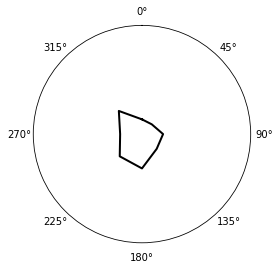

exp id 503109347


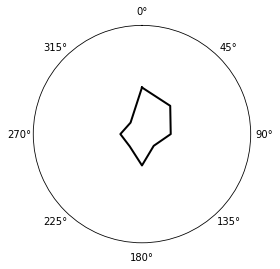

exp id 524691284


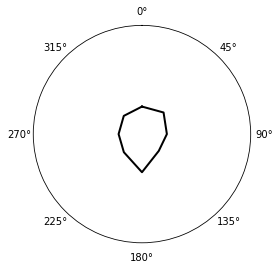

exp id 501574836


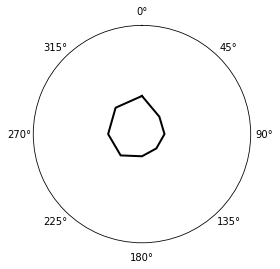

exp id 645413759


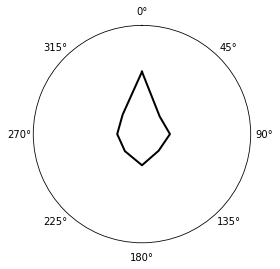

exp id 510514474


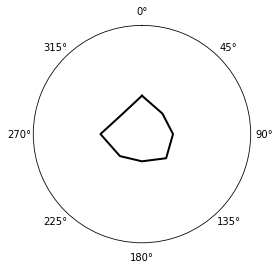

exp id 501704220


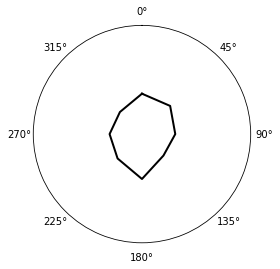

exp id 502205092


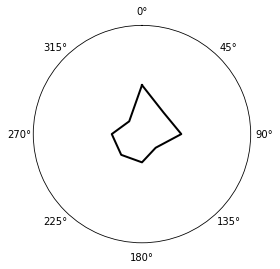

exp id 501271265


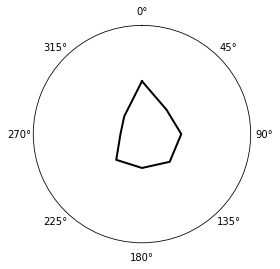

exp id 702934964


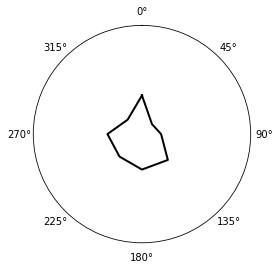

exp id 501836392


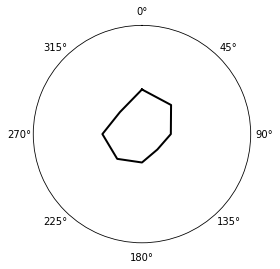

exp id 510517131


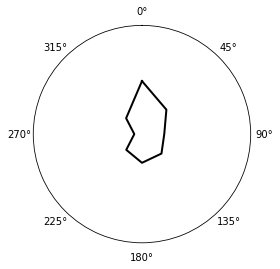

exp id 660513003


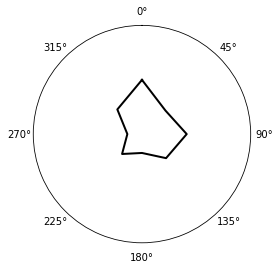

exp id 712178511


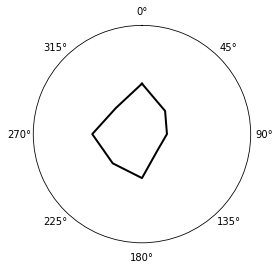

exp id 502115959


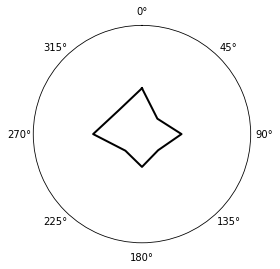

exp id 502608215


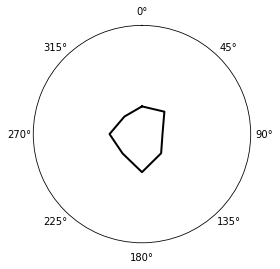

In [17]:
for i in range(len(exps)):
    e_id = exps[i]['id']
    print ("exp id", e_id)
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot(axes, thetas[i], rs[i])
    plt.show()

# Polar plot for all categories

In [ ]:
get_one_category_polar_data_cache = {}

In [ ]:
def get_one_category_polar_data(boc, targeted_structure, imaging_depth, cre_line):
    cache_key = (targeted_structure, imaging_depth, cre_line)
    if cache_key in get_one_category_polar_data_cache:
        return get_one_category_polar_data_cache[cache_key]
    
    exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
        targeted_structures = [targeted_structure],
        imaging_depths = [imaging_depth],
        cre_lines = [cre_line])
    if len(exps) == 0:
        return None, None, None, None
    print ("There are", len(exps), "experiments for ", targeted_structure, imaging_depth, cre_line)
    
    thetas = []
    rs = []
    for exp in exps:
        e_id = exp['id']
        ec_id = exp['experiment_container_id']
        print("Processing experiment", e_id)
        theta, r = get_avg_cell_polar_in_experiment(boc, ec_id, e_id, cells)
        if theta is None or len(theta) == 0:
            continue
        thetas.append(theta)
        rs.append(r)
        
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    
    if len(thetas) == 0:
        agg_theta, agg_r, thetas, rs= None, None, None, None
    
    get_one_category_polar_data_cache[cache_key] = (agg_theta, agg_r, thetas, rs)
    return get_one_category_polar_data_cache[cache_key]


In [ ]:
get_one_category_polar_data(boc, 'VISp', 175, 'Pvalb-IRES-Cre')

In [ ]:
agg_theta, agg_r, thetas, rs = get_one_category_polar_data(boc, 'VISp', 175, 'Cux2-CreERT2')
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
    bold_theta = agg_theta,
    bold_r = agg_r,
    grey_thetas = thetas, 
    grey_rs = rs)

In [ ]:
def plot_one_brain_area_chart(boc, targeted_structure, imaging_depths, cre_lines):
    """
    - brain_area (string): e.g. 'V1'
    - layers (string[]): Order of layers, where each row = 1 layer. E.g. 'L2/3'
    - cre_lines {string[]}: Order of columns, where each column = 1 celltype. E.g. 'SST'
    """
    fig, axes = plt.subplots(
        nrows=len(imaging_depths),
        ncols=len(cre_lines),
        figsize=(10,10),
        subplot_kw=dict(polar=True))
    fig.suptitle(targeted_structure, fontsize=32, y = 1.1)
    
    for ax, cre_line in zip(axes[0], cre_lines):
        ax.set_title(cre_line, fontsize=16, y = 1.3)

    for ax, imaging_depth in zip(axes[:,0], imaging_depths):
        print ("setting depth", ax, imaging_depth)
        ax.set_ylabel(str(imaging_depth), rotation=0, fontsize=16, labelpad = 50)
    
    for ax in axes.flatten():
        ax.axis('on')
    
    for imaging_depth in imaging_depths:
        for cre_line in cre_lines:
            agg_theta, agg_r, thetas, rs = get_one_category_polar_data(
                boc,
                targeted_structure,
                imaging_depth,
                cre_line)
            if agg_theta is None:
                continue
            # Get the axis given layer and celltype, then plot
            imaging_depth_id = imaging_depths.index(imaging_depth)
            cre_line_id = cre_lines.index(cre_line)
            ax = axes[imaging_depth_id, cre_line_id]
            ax.axis('on')
            polar_plot_population(ax=ax,
                bold_theta = agg_theta,
                bold_r = agg_r,
                grey_thetas = thetas, 
                grey_rs = rs)
    fig.tight_layout()
    
#plot_one_brain_area_chart(boc, 'VISp', boc.get_all_imaging_depths(), boc.get_all_cre_lines())
plot_one_brain_area_chart(boc, 'VISp', [175, 265, 275, 300, 325], ['Cux2-CreERT2', 'Emx1-IRES-Cre'])